# Importing Packages

In this section, we will import the necessary Python packages for our analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import folium
from wordcloud import WordCloud

In [2]:
# styles
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
sns.set_palette('husl')

# Seattle Airbnb Open Data - Calendar

### Data importation

In [3]:
calendar = pd.read_csv("data/calendar.csv")

### Data exploration

In [6]:
calendar

listing_id        date available   price
0            241032  2016-01-04         t  $85.00
1            241032  2016-01-05         t  $85.00
2            241032  2016-01-06         f     NaN
3            241032  2016-01-07         f     NaN
4            241032  2016-01-08         f     NaN
...             ...         ...       ...     ...
1393565    10208623  2016-12-29         f     NaN
1393566    10208623  2016-12-30         f     NaN
1393567    10208623  2016-12-31         f     NaN
1393568    10208623  2017-01-01         f     NaN
1393569    10208623  2017-01-02         f     NaN

[1393570 rows x 4 columns]

In [5]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


This dataset has missing values only in the "price" column, which occur on the days when the listing is not available. We will now verify this hypothesis.

In [6]:
# Subset the dataframe to only include rows where "price" is missing
missing_price = calendar[calendar['price'].isnull()]

# Check if the missing values in "price" only occur when "available" is "f"
only_unavailable = missing_price['available'].unique() == ['f']

if only_unavailable:
    print("The missing values in 'price' only occur when 'available' is 'f'.")
else:
    print("The missing values in 'price' occur when 'available' is not 'f', or there are missing values in other columns.")

The missing values in 'price' only occur when 'available' is 'f'.


In [7]:
calendar.duplicated().sum()

0

### Handling missing data

In [8]:
# Impute missing values in the "price" column with "Not available"
calendar.loc[calendar['available'] == 'f', 'price'] = 'Not available'

In [9]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       1393570 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


### Convert data types

In [10]:
# Convert the "date" column to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

In [11]:
# Removing "$" and convert "price" column to float except where is the string "Not available"
def clean_price(price):
    if price == 'Not available':
        return price
    else:
        return float(price[1:].replace(",",""))
calendar['price'] = calendar['price'].apply(clean_price)

In [12]:
# replace 't' with 1 and 'f' with 0 in the 'available' column
calendar['available'] = calendar['available'].replace({'t': 1, 'f': 0})

In [13]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  int64         
 3   price       1393570 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 42.5+ MB


In [14]:
calendar.head()

listing_id       date  available          price
0      241032 2016-01-04          1           85.0
1      241032 2016-01-05          1           85.0
2      241032 2016-01-06          0  Not available
3      241032 2016-01-07          0  Not available
4      241032 2016-01-08          0  Not available

### Exporting cleaned data

In [15]:
# Export the cleaned dataframe to a CSV file
calendar.to_csv('cleaned_data/calendar.csv', index=False)

## Statistics

In [16]:
df = calendar

# Calculate the mean price for available listings
mean_available_price = df[df['available']==1]['price'].mean()

# Calculate the median price for available listings
median_available_price = df[df['available']==1]['price'].median()

# Determine the minimum and maximum price for available listings
min_available_price = df[df['available']==1]['price'].min()
max_available_price = df[df['available']==1]['price'].max()

# Calculate the number of available listings and the total number of listings
num_available_listings = len(df[df['available']==1])
num_total_listings = len(df)

# Calculate the proportion of available listings
proportion_available = num_available_listings / num_total_listings


# Calculate the minimum and maximum dates and the range
min_date = df['date'].min()
max_date = df['date'].max()
date_range = (max_date - min_date).days + 1


# Create a new dataframe with the summary statistics
summary_df = pd.DataFrame({
    'Mean price for available listings': [mean_available_price],
    'Median price for available listings': [median_available_price],
    'Minimum price for available listings': [min_available_price],
    'Maximum price for available listings': [max_available_price],
    'Number of available listings': [num_available_listings],
    'Total number of listings': [num_total_listings],
    'Proportion of available listings': [proportion_available],
    'Minimum date': [min_date],
    'Maximum date': [max_date],
    'Date range (days)': [date_range]
})

# Transpose the dataframe and reset the index to create a column for each statistic
summary_df = summary_df.T.reset_index()

summary_df

index                    0
0     Mean price for available listings           137.944859
1   Median price for available listings                109.0
2  Minimum price for available listings                 10.0
3  Maximum price for available listings               1650.0
4          Number of available listings               934542
5              Total number of listings              1393570
6      Proportion of available listings              0.67061
7                          Minimum date  2016-01-04 00:00:00
8                          Maximum date  2017-01-02 00:00:00
9                     Date range (days)                  365

## Plots

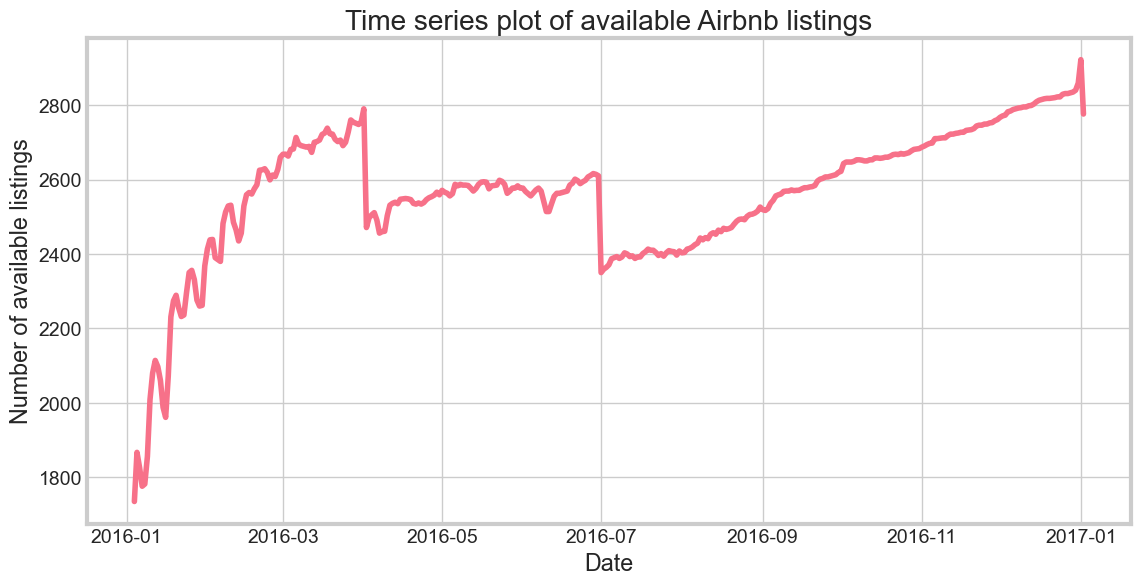

In [17]:
df_ts = df[df['available']==1].groupby('date')['available'].count()

plt.figure(figsize=(12, 6))
plt.plot(df_ts.index, df_ts.values)
plt.xlabel('Date')
plt.ylabel('Number of available listings')
plt.title('Time series plot of available Airbnb listings')
plt.grid(True)
plt.show()


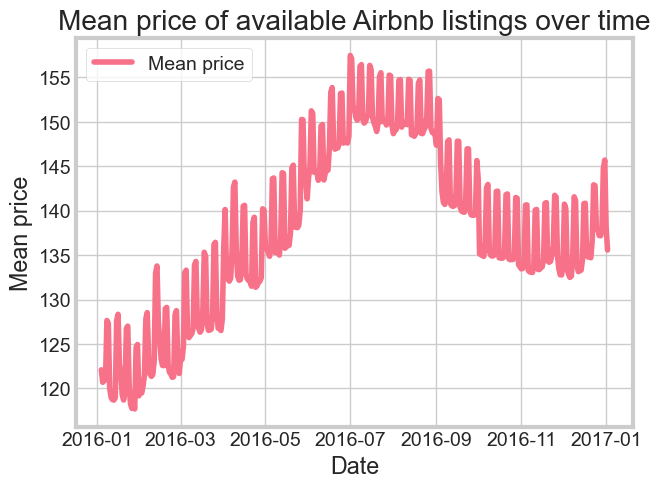

In [18]:
# Filter dataframe to only include rows where available == 1
df_available = df[df['available'] == 1]

# Group by date and calculate mean price for each date
df_ts = df_available.groupby('date')['price'].mean()

# Create a line plot of the mean price over time
plt.plot(df_ts.index, df_ts.values)

# Add labels to the x and y axes
plt.xlabel('Date')
plt.ylabel('Mean price')

plt.title('Mean price of available Airbnb listings over time')

# Add grid
plt.grid(True)

# Add legend
plt.legend(['Mean price'], loc='upper left')

# Display the plot
plt.show()


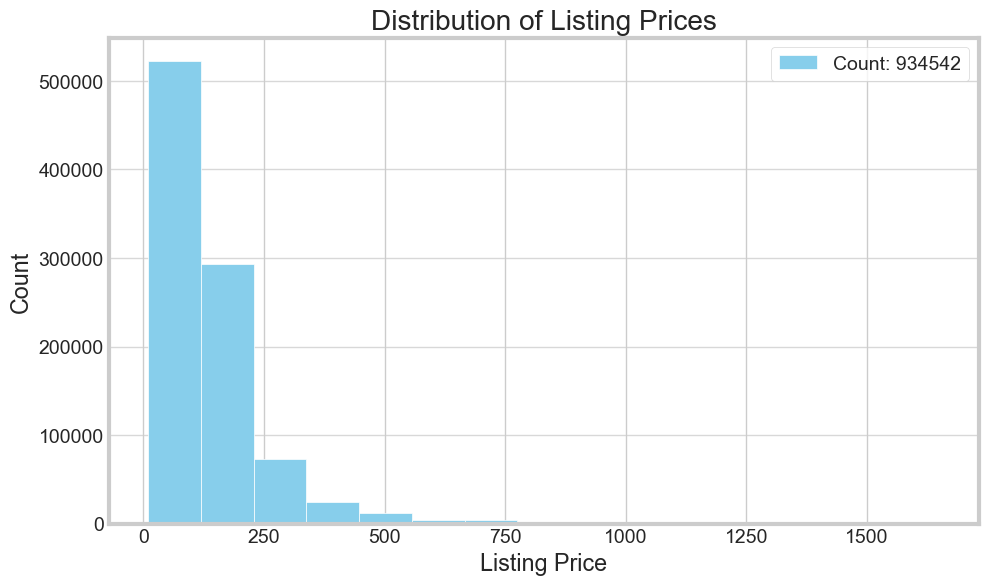

In [19]:
# Create a histogram of listing prices
plt.figure(figsize=(10, 6)) # Increase figure size
plt.hist(df_available['price'], bins=15, color='skyblue', edgecolor='white') # Add color to bars and white edgecolor
plt.xlabel('Listing Price')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75) # Add gridlines
plt.title('Distribution of Listing Prices')

# Add a legend for the color of the bars
plt.legend([f'Count: {len(df_available)}'], loc='best')

plt.show()

# Seattle Airbnb Open Data - Listings

### Data importation

In [7]:
listings = pd.read_csv("data/listings.csv")

### Data exploration

In [8]:
listings

id                            listing_url       scrape_id  \
0       241032    https://www.airbnb.com/rooms/241032  20160104002432   
1       953595    https://www.airbnb.com/rooms/953595  20160104002432   
2      3308979   https://www.airbnb.com/rooms/3308979  20160104002432   
3      7421966   https://www.airbnb.com/rooms/7421966  20160104002432   
4       278830    https://www.airbnb.com/rooms/278830  20160104002432   
...        ...                                    ...             ...   
3813   8101950   https://www.airbnb.com/rooms/8101950  20160104002432   
3814   8902327   https://www.airbnb.com/rooms/8902327  20160104002432   
3815  10267360  https://www.airbnb.com/rooms/10267360  20160104002432   
3816   9604740   https://www.airbnb.com/rooms/9604740  20160104002432   
3817  10208623  https://www.airbnb.com/rooms/10208623  20160104002432   

     last_scraped                                 name  \
0      2016-01-04         Stylish Queen Anne Apartment   
1      2016-01-04   Bright & Airy Queen Anne Apartment   
2      2016-01-04  New Modern House-Amazing water view   
3      2016-01-04                   Queen Anne Chateau   
4      2016-01-04       Charming craftsman 3 bdm house   
...           ...                                  ...   
3813   2016-01-04   3BR Mountain View House in Seattle   
3814   2016-01-04    Portage Bay View!-One Bedroom Apt   
3815   2016-01-04    Private apartment view of Lake WA   
3816   2016-01-04    Amazing View with Modern Comfort!   
3817   2016-01-04            Large Lakefront Apartment   

                                                summary  \
0                                                   NaN   
1     Chemically sensitive? We've removed the irrita...   
2     New modern house built in 2013.  Spectacular s...   
3     A charming apartment that sits atop Queen Anne...   
4     Cozy family craftman house in beautiful neighb...   
...                                                 ...   
3813  Our 3BR/2BA house boasts incredible views of t...   
3814  800 square foot 1 bedroom basement apartment w...   
3815  Very comfortable lower unit. Quiet, charming m...   
3816  Cozy studio condo in the heart on Madison Park...   
3817  All hardwood floors, fireplace, 65" TV with Xb...   

                                                  space  \
0     Make your self at home in this charming one-be...   
1     Beautiful, hypoallergenic apartment in an extr...   
2     Our house is modern, light and fresh with a wa...   
3                                                   NaN   
4     Cozy family craftman house in beautiful neighb...   
...                                                 ...   
3813  Our 3BR/2BA house bright, stylish, and wheelch...   
3814  This space has a great view of Portage Bay wit...   
3815                                                NaN   
3816  Fully furnished unit to accommodate most needs...   
3817                                                NaN   

                                            description experiences_offered  \
0     Make your self at home in this charming one-be...                none   
1     Chemically sensitive? We've removed the irrita...                none   
2     New modern house built in 2013.  Spectacular s...                none   
3     A charming apartment that sits atop Queen Anne...                none   
4     Cozy family craftman house in beautiful neighb...                none   
...                                                 ...                 ...   
3813  Our 3BR/2BA house boasts incredible views of t...                none   
3814  800 square foot 1 bedroom basement apartment w...                none   
3815  Very comfortable lower unit. Quiet, charming m...                none   
3816  Cozy studio condo in the heart on Madison Park...                none   
3817  All hardwood floors, fireplace, 65" TV with Xb...                none   

                                  neighborhood_overview  ...  \
0      

In [22]:
# Drop columns
columns_to_drop = ["city", "host_name", "listing_url", "scrape_id", "last_scraped", "summary", "space", "description", "experiences_offered", "neighborhood_overview", "notes", "transit", "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_url", "host_location", "host_about", "host_is_superhost", "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "calendar_last_scraped", "host_listings_count", "host_has_profile_pic", "neighbourhood", "requires_license", "license", "jurisdiction_names", "require_guest_profile_picture", "security_deposit", "extra_people", "minimum_nights", "maximum_nights", "cleaning_fee", "calendar_updated", "has_availability", "availability_30", "availability_60", "availability_90", "availability_365",  "require_guest_phone_verification", "calculated_host_listings_count", "weekly_price", "monthly_price", "square_feet", "state", "market", 'smart_location', 'country_code', 'country']
listings = listings.drop(columns_to_drop, axis = 1)

In [23]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3818 non-null   int64  
 1   name                          3818 non-null   object 
 2   host_id                       3818 non-null   int64  
 3   host_since                    3816 non-null   object 
 4   host_response_time            3295 non-null   object 
 5   host_response_rate            3295 non-null   object 
 6   host_acceptance_rate          3045 non-null   object 
 7   host_total_listings_count     3816 non-null   float64
 8   host_verifications            3818 non-null   object 
 9   host_identity_verified        3816 non-null   object 
 10  street                        3818 non-null   object 
 11  neighbourhood_cleansed        3818 non-null   object 
 12  neighbourhood_group_cleansed  3818 non-null   object 
 13  zip

In [24]:
listings.duplicated().sum()

0

## Convert data types

In [25]:
# remove the percentage sign and convert to float
listings['host_response_rate'] = listings['host_response_rate'].str.strip('%').astype(float) / 100 
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.strip('%').astype(float) / 100 
    
# create a list of column names to convert to datetime
columns_to_datetime = ["host_since", "first_review", "last_review"]

# convert each column to datetime
for column in columns_to_datetime:
    listings[column] = pd.to_datetime(listings[column]).dt.date
    
# clean price
listings['price'] = listings['price'].apply(clean_price)

# create a list of column names to convert to string
columns_to_string = ["name", "host_response_time", "street", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "property_type", "room_type", "bed_type"]

# convert each column to string
for column in columns_to_string:
    listings[column] = listings[column].astype(str)

In [26]:
replacement_dict = {'t': 1, 'f': 0}

listings[["host_identity_verified", "is_location_exact", "instant_bookable"]] = listings[["host_identity_verified", "is_location_exact", "instant_bookable"]].replace(replacement_dict)

In [27]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3818 non-null   int64  
 1   name                          3818 non-null   object 
 2   host_id                       3818 non-null   int64  
 3   host_since                    3816 non-null   object 
 4   host_response_time            3818 non-null   object 
 5   host_response_rate            3295 non-null   float64
 6   host_acceptance_rate          3045 non-null   float64
 7   host_total_listings_count     3816 non-null   float64
 8   host_verifications            3818 non-null   object 
 9   host_identity_verified        3816 non-null   float64
 10  street                        3818 non-null   object 
 11  neighbourhood_cleansed        3818 non-null   object 
 12  neighbourhood_group_cleansed  3818 non-null   object 
 13  zip

## Handle missing data

In [28]:
# Calculate the percentage of missing values per column
percent_missing = listings.isnull().sum() * 100 / len(listings)

# Create a table to display the results
missing_value_df = pd.DataFrame({'column_name': listings.columns,
                                 'percent_missing': percent_missing})

# Sort the table by percentage of missing values (descending order)
missing_value_df = missing_value_df.sort_values('percent_missing', ascending=False)

# Display the table
print(missing_value_df)

                                               column_name  percent_missing
host_acceptance_rate                  host_acceptance_rate        20.246202
review_scores_checkin                review_scores_checkin        17.234154
review_scores_accuracy              review_scores_accuracy        17.234154
review_scores_value                    review_scores_value        17.181771
review_scores_location              review_scores_location        17.155579
review_scores_cleanliness        review_scores_cleanliness        17.103195
review_scores_communication    review_scores_communication        17.050812
review_scores_rating                  review_scores_rating        16.946045
reviews_per_month                        reviews_per_month        16.422211
first_review                                  first_review        16.422211
last_review                                    last_review        16.422211
host_response_rate                      host_response_rate        13.698271
bathrooms   

In [29]:
def impute_mean(df, columns):
    for column in columns:
        mean_value = df[column].mean()
        df[column] = df[column].fillna(mean_value)
    return df

In [30]:
listings = impute_mean(listings, ["host_acceptance_rate", "review_scores_accuracy", "review_scores_checkin", "review_scores_value", "review_scores_location", "review_scores_cleanliness", "review_scores_communication", "review_scores_rating", "reviews_per_month", "host_response_rate"])

In [31]:
listings["host_response_time"].fillna(listings["host_response_time"].mode()[0], inplace = True)

In [32]:
listings["first_review"] = listings["first_review"].fillna(method='ffill')
listings["last_review"] = listings["last_review"].fillna(method='ffill')

In [33]:
listings.dropna(inplace = True)

In [34]:
listings.isna().sum().sum()

0

In [35]:
# convert host_total_listing_count to int, now that it doesnt have nan
listings['host_total_listings_count'] = listings['host_total_listings_count'].astype(int)

# same for zipcode
listings['zipcode'] = listings['zipcode'].apply(lambda x: int(''.join(filter(str.isdigit, x))))

In [36]:
# create a list of column names to convert to datetime
columns_to_datetime = ["host_since", "first_review", "last_review"]

# convert each column to datetime
for column in columns_to_datetime:
    listings[column] = pd.to_datetime(listings[column])

## Exporting cleaned data

In [37]:
# Export the cleaned dataframe to a CSV file
listings.to_csv('cleaned_data/listings.csv', index=False)

## Statistics

In [38]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3817
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            3787 non-null   int64         
 1   name                          3787 non-null   object        
 2   host_id                       3787 non-null   int64         
 3   host_since                    3787 non-null   datetime64[ns]
 4   host_response_time            3787 non-null   object        
 5   host_response_rate            3787 non-null   float64       
 6   host_acceptance_rate          3787 non-null   float64       
 7   host_total_listings_count     3787 non-null   int32         
 8   host_verifications            3787 non-null   object        
 9   host_identity_verified        3787 non-null   float64       
 10  street                        3787 non-null   object        
 11  neighbourhood_cleansed        

In [39]:
df = listings

In [40]:
# Calculate the number of hosts
num_hosts = df['host_id'].nunique()

# Calculate host response rate
host_response_rate = df['host_response_rate'].mean()

# Calculate host acceptance rate
host_acceptance_rate = df['host_acceptance_rate'].mean()

# Calculate average number of listings per host
avg_listings_per_host = df['host_total_listings_count'].mean()


# Create a new dataframe to store the results
host_stats_df = pd.DataFrame({'Number of Hosts': [num_hosts],
                              'Average Host Response Rate': [host_response_rate],
                              'Average Host Acceptance Rate': [host_acceptance_rate],
                              'Average Listings per Host': [avg_listings_per_host]})

# Print the results
host_stats_df.T

0
Number of Hosts               2740.000000
Average Host Response Rate       0.948916
Average Host Acceptance Rate     0.999670
Average Listings per Host        7.097703

In [41]:
# Get the value counts of each neighborhood
neighbourhood_counts = listings["neighbourhood_cleansed"].value_counts()

# Calculate the proportion of each neighborhood
neighbourhood_proportions = listings["neighbourhood_cleansed"].value_counts(normalize=True)

# Create a dataframe
neighbourhood_stats = pd.DataFrame({
    "Frequency": neighbourhood_counts,
    "Proportion": neighbourhood_proportions,
})

# Print the dataframe
neighbourhood_stats

Frequency  Proportion
Broadway                 391    0.103248
Belltown                 227    0.059942
Wallingford              167    0.044098
Fremont                  158    0.041722
Minor                    135    0.035648
...                      ...         ...
Arbor Heights              5    0.001320
Pinehurst                  4    0.001056
South Beacon Hill          4    0.001056
South Park                 3    0.000792
Roxhill                    2    0.000528

[87 rows x 2 columns]

In [42]:
# Calculate statistics for numerical columns
num_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']
num_stats = listings[num_cols].agg([np.min, np.max, np.mean, np.median, np.std]).transpose()

# Calculate frequency counts, proportions, and mode for categorical columns
cat_cols = ['property_type', 'room_type', 'bed_type']
cat_stats = pd.DataFrame()
for col in cat_cols:
    uniquevalues = listings[col].unique()
    mode = listings[col].mode().iloc[0]
    cat_stats[col] = pd.Series({'unique values': uniquevalues, 'mode': mode})

In [43]:
num_stats

amin    amax        mean  median        std
accommodates   1.0    16.0    3.349617     3.0   1.975892
bathrooms      0.0     8.0    1.259440     1.0   0.590435
bedrooms       0.0     7.0    1.308424     1.0   0.883577
beds           1.0    15.0    1.737259     1.0   1.141075
price         20.0  1000.0  127.954581   100.0  90.374145

In [44]:
pd.options.display.max_colwidth = None

In [45]:
cat_stats

property_type  \
unique values  [Apartment, House, Cabin, Condominium, Camper/RV, Bungalow, Townhouse, Loft, Boat, Other, Dorm, Bed & Breakfast, Treehouse, Yurt, Chalet, Tent, nan]   
mode                                                                                                                                                          House   

                                                  room_type  \
unique values  [Entire home/apt, Private room, Shared room]   
mode                                        Entire home/apt   

                                                      bed_type  
unique values  [Real Bed, Futon, Pull-out Sofa, Airbed, Couch]  
mode                                                  Real Bed

In [46]:
listings.iloc[:,30:].describe()

review_scores_rating  review_scores_accuracy  \
count           3787.000000             3787.000000   
mean              94.549809                9.636465   
std                6.024127                0.636449   
min               20.000000                2.000000   
25%               94.000000                9.636392   
50%               95.000000               10.000000   
75%               98.000000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                3787.000000            3787.000000   
mean                    9.557548               9.788526   
std                     0.724772               0.537612   
min                     3.000000               2.000000   
25%                     9.000000               9.786709   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                  3787.000000             3787.000000   
mean                      9.811297                9.610398   
std                       0.509937                0.572361   
min                       2.000000                4.000000   
25%                       9.809599                9.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  instant_bookable  reviews_per_month  
count          3787.000000       3787.000000        3787.000000  
mean              9.453791          0.154476           2.082490  
std               0.682568          0.361452           1.666338  
min               2.000000          0.000000           0.020000  
25%               9.000000          0.000000           0.840000  
50%               9.452245          0.000000           2.000000  
75%              10.000000          0.000000           2.665000  
max              10.000000          1.000000          12.150000

## Plots

<AxesSubplot:title={'center':'Room Type Distribution'}, ylabel='room_type'>

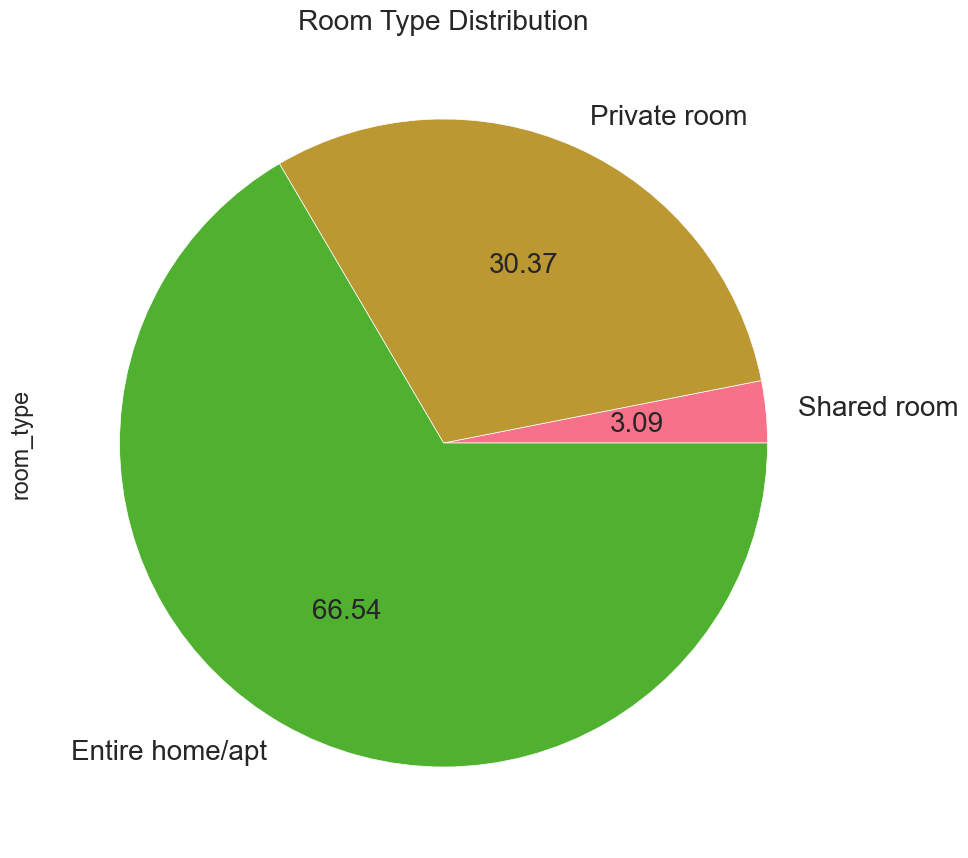

In [47]:
room = listings.room_type
r = Counter(room)

room_df = pd.DataFrame.from_dict(r, orient='index').sort_values(by=0)
room_df.columns = ['room_type']
room_df.plot.pie(y = 'room_type', 
                 figsize=(10,10), 
                 fontsize = 20, autopct = '%.2f',
                 legend = False,
                 title = 'Room Type Distribution')

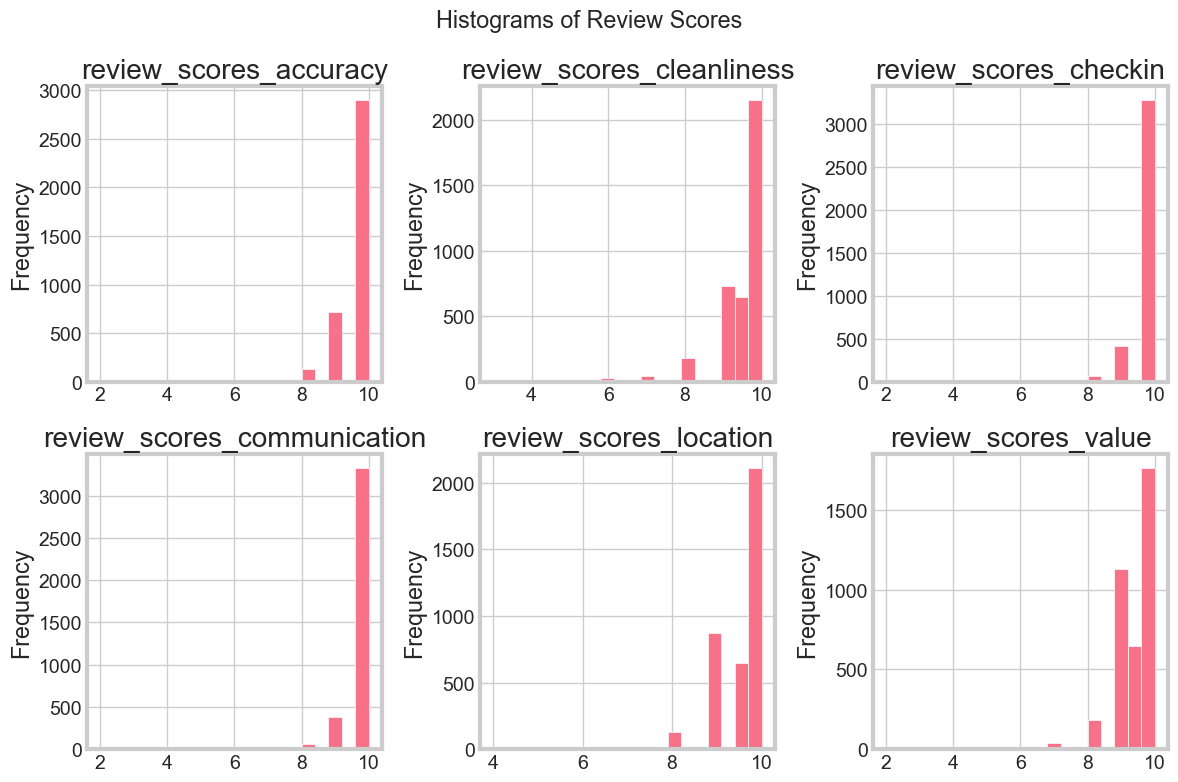

In [48]:
# List of columns to plot
detail_score_rating_l = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Plot each histogram
for i, col in enumerate(detail_score_rating_l):
    ax = axes[i//3, i%3] # Get the subplot axes for the i-th histogram
    listings[col].plot.hist(ax=ax, bins=20)
    ax.set_title(col)

# Add overall title
fig.suptitle('Histograms of Review Scores')

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

In [49]:
# Get listing coordinates
listing_coordinates = listings[['latitude', 'longitude']]

# Create a Folium map centered on Seattle
m = folium.Map(location=[47.608013, -122.335167], zoom_start=12)

# Loop through each row in the listing coordinates dataframe and add a CircleMarker to the map
for row in listing_coordinates.iterrows():
    folium.CircleMarker(location=[row[1]['latitude'], row[1]['longitude']], radius=0.25, fill=True, fill_color='blue').add_to(m)

# Display the map
m


# Seattle Airbnb Open Data - Reviews

## Data importation

In [50]:
reviews = pd.read_csv("data/reviews.csv")

## Data exploration

In [51]:
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                                                                                                                                                                                                                                                                                                                                                                                         comments  
0                                                                                                                                                                                                                                                                                                                                                           Cute and cozy place. Perfect location to everything!   
1  Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW.  Thanks for a great stay.  
2      Very spacious apartment, and in a great neighborhood.  This is the kind of apartment I wish I had!\r\n\r\nDidn't really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only "issue" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday  
3                                                                                                                          Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the Metropolitan (probably the coolest grocer you'll ever find). Easy to find and Kelly was warm, welcoming, and really interesting to talk to.   
4                                                              Kelly was a great host and very accommodating in a great neighborhood. She has some great coffee and while I wasn't around much during my stay the time I spent interacting with her was very pleasant. \r\n\r\nThe apartment is in a great location and very close to the Seattle Center. The neighborhood itself has a lot of good food as well!

In [52]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [53]:
reviews.duplicated().sum()

0

## Handling missing data

In [54]:
reviews.dropna(inplace = True)

In [55]:
reviews.isna().sum().sum()

0

## Convert data types

In [56]:
# convert date to datetime
reviews["date"] = pd.to_datetime(reviews["date"])

# create a list of column names to convert to string
columns_to_string = ["reviewer_name", "comments"]

# convert each column to string
for column in columns_to_string:
    reviews[column] = reviews[column].astype(str)

In [57]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84831 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     84831 non-null  int64         
 1   id             84831 non-null  int64         
 2   date           84831 non-null  datetime64[ns]
 3   reviewer_id    84831 non-null  int64         
 4   reviewer_name  84831 non-null  object        
 5   comments       84831 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.5+ MB


## Exporting cleaned data

In [58]:
# Export the cleaned dataframe to a CSV file
reviews.to_csv('cleaned_data/reviews.csv', index=False)

## Statistics

In [59]:
df = reviews

In [60]:
# Group the data by reviewer and count the number of reviews submitted by each reviewer
reviewer_counts = df.groupby(['reviewer_id', 'reviewer_name']).size().reset_index(name='num_reviews')

# Sort the DataFrame by the number of reviews in descending order
reviewer_counts = reviewer_counts.sort_values('num_reviews', ascending=False)

# Print the reviewer distribution DataFrame
reviewer_counts

reviewer_id reviewer_name  num_reviews
1188        206203        Amanda           67
38154     15121499       Kathryn           32
11565      2734499         Jason           19
19977      5775807         David           19
58391     29590276          Gerd           18
...            ...           ...          ...
26832      8574337        Lauren            1
26833      8575076     Christina            1
26834      8575094        Garett            1
26835      8575117       Cynthia            1
75716     52812740          Arin            1

[75717 rows x 3 columns]

In [61]:
# Print the date range of the 'date' column
print('Date range:', df['date'].min(), 'to', df['date'].max())

Date range: 2009-06-07 00:00:00 to 2016-01-03 00:00:00


## Plots

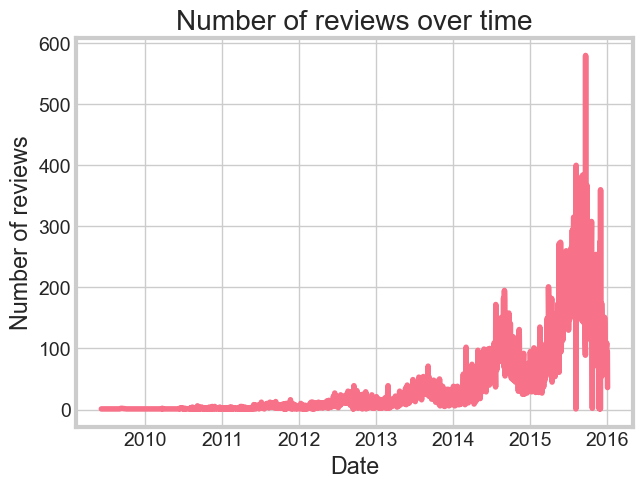

In [62]:
# Group the data by date and count the number of reviews for each date
review_counts = df.groupby('date').count()['id']

# Plot the number of reviews over time
plt.plot(review_counts.index, review_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of reviews')
plt.title('Number of reviews over time')
plt.show()

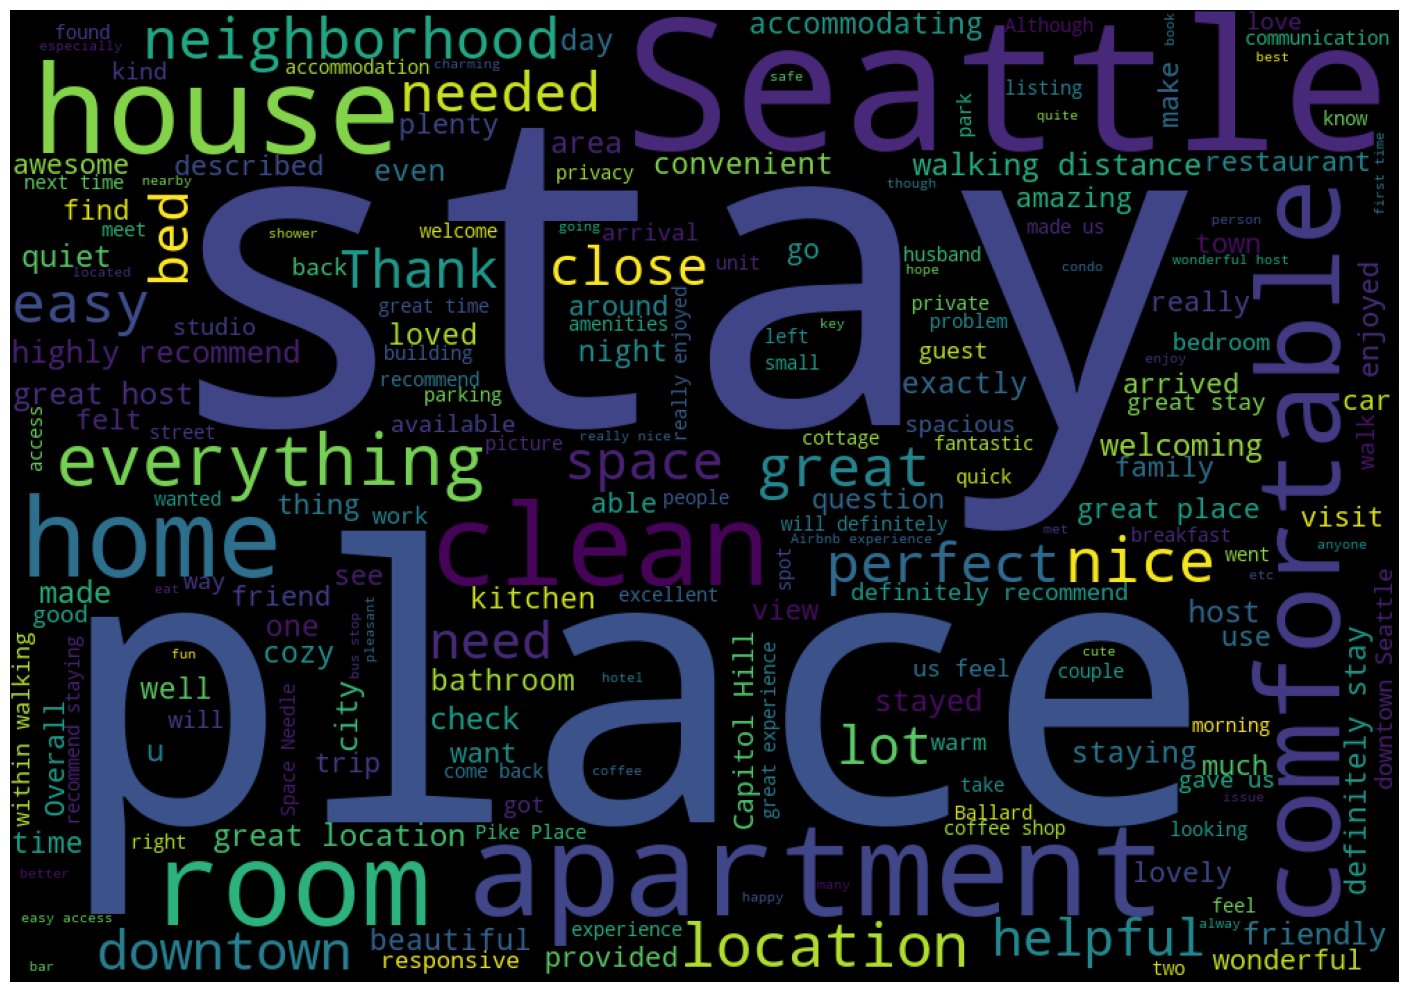

In [63]:
# Combine all comments into a single string
all_comments = ' '.join(df['comments'].tolist())

wordcloud = WordCloud(width = 1000, height = 700).generate(all_comments)
plt.figure(figsize=(18,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Seattle parks and recreation park addresses

## Data importation

In [9]:
parks = pd.read_csv("data/seattle-parks-and-recreation-park-addresses.csv")

## Data exploration

In [10]:
parks

PMAID  LocID                       Name            Address  ZIP Code  \
0        281   2545    12th and Howe Play Park     1200 W Howe St     98119   
1       4159   2387       12th Ave S Viewpoint    2821 12TH Ave S     98144   
2       4467   2382       12th Ave Square Park       564 12th Ave     98122   
3       4010   2546      14th Ave NW Boat Ramp   4400 14th Ave NW     98107   
4        296    296             3001 E Madison  3001 E Madison St     98112   
..       ...    ...                        ...                ...       ...   
407  1000292    292  Woodland Park Rose Garden      750 N 50th St     98103   
408      200   9909          Woodland Park Zoo      700 N 50th St     98103   
409     4563      0           Yesler Playfield     835 Yesler Way     98104   
410      580   1712                  York Park  3650 Renton Ave S     98144   
411     3926   1816            York Playground    3327 34th Ave S     98126   

        X Coord    Y Coord                                         Location 1  
0   -122.372985  47.636097  {'longitude': '-122.372985', 'needs_recoding':...  
1   -122.317765  47.577953  {'longitude': '-122.317765', 'needs_recoding':...  
2   -122.316455  47.607427  {'longitude': '-122.316455', 'needs_recoding':...  
3   -122.373536  47.660775  {'longitude': '-122.373536', 'needs_recoding':...  
4   -122.293173  47.625169  {'longitude': '-122.293173', 'needs_recoding':...  
..          ...        ...                                                ...  
407 -122.350540  47.666499  {'longitude': '-122.35054', 'needs_recoding': ...  
408 -122.350430  47.666183  {'longitude': '-122.35043', 'needs_recoding': ...  
409 -122.320083  47.601262  {'longitude': '-122.320083', 'needs_recoding':...  
410 -122.295537  47.570461  {'longitude': '-122.295537', 'needs_recoding':...  
411 -122.290713  47.572695  {'longitude': '-122.290713', 'needs_recoding':...  

[412 rows x 8 columns]

In [66]:
parks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PMAID       412 non-null    int64  
 1   LocID       412 non-null    int64  
 2   Name        412 non-null    object 
 3   Address     412 non-null    object 
 4   ZIP Code    412 non-null    int64  
 5   X Coord     412 non-null    float64
 6   Y Coord     412 non-null    float64
 7   Location 1  412 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 25.9+ KB


In [67]:
parks.duplicated().sum()

0

In [68]:
parks = parks.drop(["Location 1"], axis = 1)
parks.head()

PMAID  LocID                     Name            Address  ZIP Code  \
0    281   2545  12th and Howe Play Park     1200 W Howe St     98119   
1   4159   2387     12th Ave S Viewpoint    2821 12TH Ave S     98144   
2   4467   2382     12th Ave Square Park       564 12th Ave     98122   
3   4010   2546    14th Ave NW Boat Ramp   4400 14th Ave NW     98107   
4    296    296           3001 E Madison  3001 E Madison St     98112   

      X Coord    Y Coord  
0 -122.372985  47.636097  
1 -122.317765  47.577953  
2 -122.316455  47.607427  
3 -122.373536  47.660775  
4 -122.293173  47.625169

## Convert data types

In [69]:
# create a list of column names to convert to string
columns_to_string = ["Name", "Address"]

# convert each column to string
for column in columns_to_string:
    parks[column] = parks[column].astype(str)

In [70]:
parks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PMAID     412 non-null    int64  
 1   LocID     412 non-null    int64  
 2   Name      412 non-null    object 
 3   Address   412 non-null    object 
 4   ZIP Code  412 non-null    int64  
 5   X Coord   412 non-null    float64
 6   Y Coord   412 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 22.7+ KB


## Exporting cleaned data

In [71]:
# Export the cleaned dataframe to a CSV file
parks.to_csv('cleaned_data/parks.csv', index=False)

## Plots

In [72]:
df = parks

In [73]:

# Create a map centered on the mean of the X and Y coordinates
m = folium.Map(location=[df['Y Coord'].mean(), df['X Coord'].mean()], zoom_start=12)

# Add a marker for each point on the map
for index, row in df.iterrows():
    folium.CircleMarker([row['Y Coord'], row['X Coord']], radius=2, fill=True).add_to(m)

# Display the map
m

# Seattle Weather

## Data importation

In [11]:
weather = pd.read_csv("data/seattleWeather_1948-2017.csv")

## Data exploration

In [12]:
weather

DATE  PRCP  TMAX  TMIN   RAIN
0      1948-01-01  0.47    51    42   True
1      1948-01-02  0.59    45    36   True
2      1948-01-03  0.42    45    35   True
3      1948-01-04  0.31    45    34   True
4      1948-01-05  0.17    45    32   True
...           ...   ...   ...   ...    ...
25546  2017-12-10  0.00    49    34  False
25547  2017-12-11  0.00    49    29  False
25548  2017-12-12  0.00    46    32  False
25549  2017-12-13  0.00    48    34  False
25550  2017-12-14  0.00    50    36  False

[25551 rows x 5 columns]

In [76]:
weather.tail()

DATE  PRCP  TMAX  TMIN   RAIN
25546  2017-12-10   0.0    49    34  False
25547  2017-12-11   0.0    49    29  False
25548  2017-12-12   0.0    46    32  False
25549  2017-12-13   0.0    48    34  False
25550  2017-12-14   0.0    50    36  False

In [77]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25551 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25551 non-null  int64  
 3   TMIN    25551 non-null  int64  
 4   RAIN    25548 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


In [78]:
weather.describe()

PRCP          TMAX          TMIN
count  25548.000000  25551.000000  25551.000000
mean       0.106222     59.544206     44.514226
std        0.239031     12.772984      8.892836
min        0.000000      4.000000      0.000000
25%        0.000000     50.000000     38.000000
50%        0.000000     58.000000     45.000000
75%        0.100000     69.000000     52.000000
max        5.020000    103.000000     71.000000

In [79]:
weather.duplicated().sum()

0

## Handling missing data

In [80]:
weather.dropna(inplace = True)

In [81]:
weather.isna().sum().sum()

0

## Convert data types

In [82]:
# Convert the "date" column to datetime
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [83]:
weather['RAIN'] = weather['RAIN'].astype(int)

In [84]:
weather.head()

DATE  PRCP  TMAX  TMIN  RAIN
0 1948-01-01  0.47    51    42     1
1 1948-01-02  0.59    45    36     1
2 1948-01-03  0.42    45    35     1
3 1948-01-04  0.31    45    34     1
4 1948-01-05  0.17    45    32     1

In [85]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25548 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    25548 non-null  datetime64[ns]
 1   PRCP    25548 non-null  float64       
 2   TMAX    25548 non-null  int64         
 3   TMIN    25548 non-null  int64         
 4   RAIN    25548 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2)
memory usage: 1.1 MB


## Exporting cleaned data

In [86]:
# Export the cleaned dataframe to a CSV file
weather.to_csv('cleaned_data/weather.csv', index=False)

## Statistics

In [87]:
df = weather

In [88]:
# Calculate total rainfall over the entire period
total_rainfall = df['PRCP'].sum()

# Calculate number of rainy days
num_rainy_days = df['RAIN'].sum()

# Calculate maximum and minimum amount of rainfall in a single day
max_daily_rainfall = df['PRCP'].max()
min_daily_rainfall = df['PRCP'].min()

# Calculate average daily rainfall
avg_daily_rainfall = df['PRCP'].mean()

# Create a new DataFrame with the rainfall statistics
rainfall_stats = pd.DataFrame({
    'Total rainfall': [total_rainfall],
    'Number of rainy days': [num_rainy_days],
    'Maximum daily rainfall': [max_daily_rainfall],
    'Minimum daily rainfall': [min_daily_rainfall],
    'Average daily rainfall': [avg_daily_rainfall]
})

# Print the rainfall statistics DataFrame
rainfall_stats.T

0
Total rainfall           2713.750000
Number of rainy days    10900.000000
Maximum daily rainfall      5.020000
Minimum daily rainfall      0.000000
Average daily rainfall      0.106222

## Plots

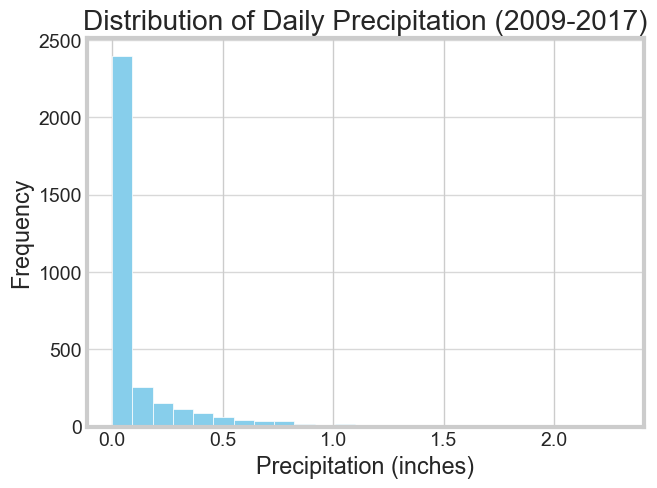

In [89]:
# Filter data from beginning of 2009
df_2009 = df[df['DATE'] >= '2009-01-01']

# create histogram of daily precipitation
plt.hist(df_2009['PRCP'], bins=25, color='skyblue', edgecolor='white')

# add title and axis labels
plt.title('Distribution of Daily Precipitation (2009-2017)')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75) # Add gridlines

# show plot
plt.show()

C:\Users\Filipa\AppData\Local\Temp\ipykernel_19652\825760503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2009['DOY'] = df_2009['DATE'].dt.dayofyear
C:\Users\Filipa\AppData\Local\Temp\ipykernel_19652\825760503.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df_2009.groupby('DOY')['TMAX', 'TMIN'].mean()


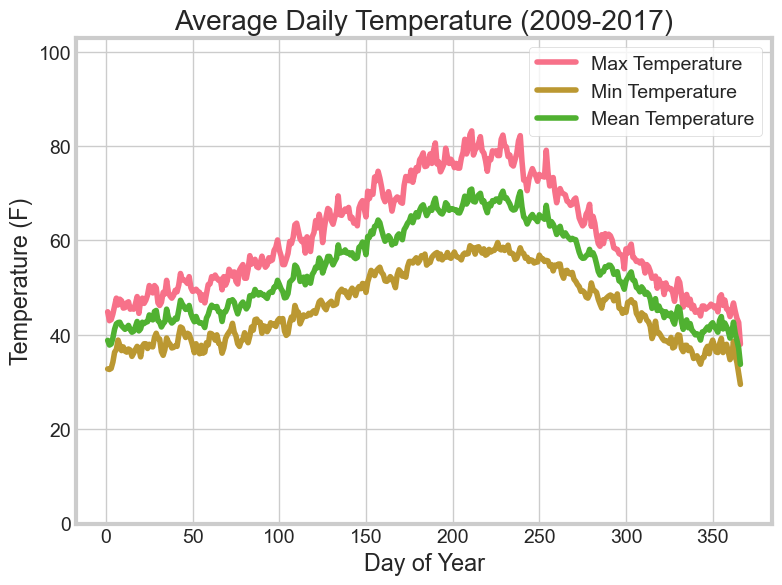

In [90]:
# extract day of the year
df_2009['DOY'] = df_2009['DATE'].dt.dayofyear

# group by DOY and calculate mean for TMAX, TMIN, and mean temperature
df_grouped = df_2009.groupby('DOY')['TMAX', 'TMIN'].mean()
df_grouped['TMEAN'] = (df_grouped['TMAX'] + df_grouped['TMIN']) / 2

# plot the data
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df_grouped.index, df_grouped['TMAX'], label='Max Temperature')
ax.plot(df_grouped.index, df_grouped['TMIN'], label='Min Temperature')
ax.plot(df_grouped.index, df_grouped['TMEAN'], label='Mean Temperature')
ax.set_ylabel('Temperature (F)')
ax.set_xlabel('Day of Year')
ax.set_ylim([0, 103])
ax.legend()

plt.title('Average Daily Temperature (2009-2017)')

plt.show()
